## Coding Discussion 06
### Charlie Zhang

In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

### Data

In [2]:
## Read the training data
train = pd.read_csv("../train_data.csv")

In [3]:
## See the columns of training data
train.columns

Index(['OBJECTID', 'SSL', 'BATHRM', 'HF_BATHRM', 'HEAT', 'HEAT_D', 'AC',
       'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES',
       'SALEDATE', 'QUALIFIED', 'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE',
       'STYLE_D', 'STRUCT', 'STRUCT_D', 'GRADE', 'GRADE_D', 'CNDTN', 'CNDTN_D',
       'EXTWALL', 'EXTWALL_D', 'ROOF', 'ROOF_D', 'INTWALL', 'INTWALL_D',
       'KITCHENS', 'FIREPLACES', 'USECODE', 'LANDAREA', 'GIS_LAST_MOD_DTTM',
       'LN_PRICE'],
      dtype='object')

<AxesSubplot:>

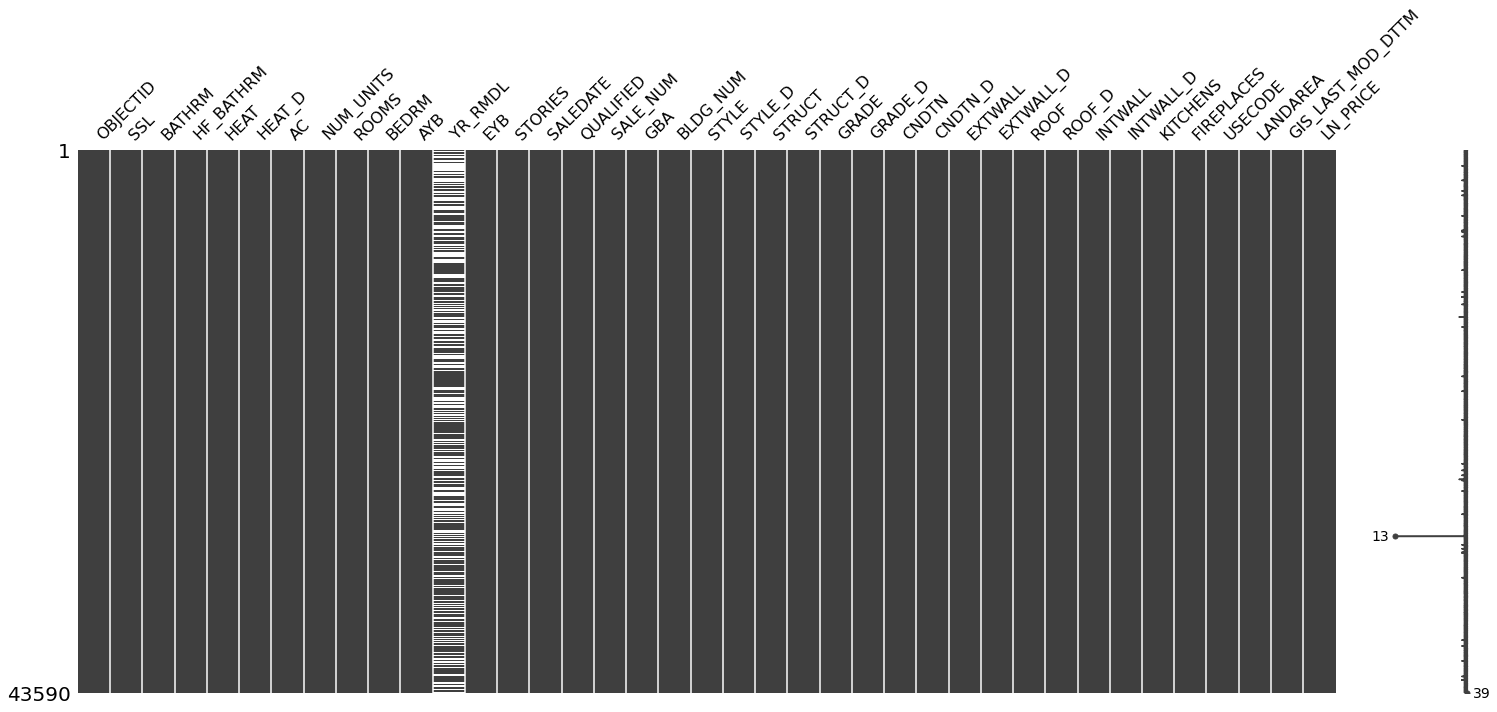

In [4]:
## Have a look at the missing data
miss.matrix(train)

In [5]:
## Drop all observations where the outcome is missing 
train = train[~train.LN_PRICE.isna()]

## Only keep those logged prices are not zero
train = train[train.LN_PRICE != 0]

## Log the building area for scaling 
train['GBA'] = np.log(train['GBA'])

## Drop any values with NA
train = train.dropna()

In [6]:
## Select the outcome variable `LN_PRICE`
train_y = train["LN_PRICE"]

In [8]:
## Select predictor variables
train_X = train[["BATHRM", "HF_BATHRM", "AC", "BEDRM", "AYB", "GBA", "GRADE", "KITCHENS", "CNDTN", "LANDAREA"]]

In [9]:
train_X.isnull().sum()

BATHRM       0
HF_BATHRM    0
AC           0
BEDRM        0
AYB          0
GBA          0
GRADE        0
KITCHENS     0
CNDTN        0
LANDAREA     0
dtype: int64

For the predictor variables, I look through each one's description and select the most relevant factors, including `BATHRM` (number of bathrooms), `HF_BATHRM` (number of half-bathrooms), `AC` (air conditioning in residence), `BEDRM` (number of bedrooms), `AYB` (The earliest time the main portion of the building was built), `GBA` (gross building area in square feet), `KITCHENS` (number of Kitchens), `GRADE`, `CNDTN`, and `LANDAREA`.

### Pre-Processing

In [10]:
## Change AC from Y or N to 1 or 0
train_X["AC"] = np.where(train_X["AC"] == "Y", 1, 0)

In [11]:
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

In [12]:
## Convert back into data frame
train_X = pd.DataFrame(train_X,columns=col_names)
train_X

,BATHRM,HF_BATHRM,AC,BEDRM,AYB,GBA,GRADE,KITCHENS,CNDTN,LANDAREA
0,0.272727,0.090909,1.0,0.074074,0.962283,0.308304,0.416667,0.022727,0.833333,0.012962
1,0.181818,0.181818,1.0,0.074074,0.962779,0.468906,0.500000,0.022727,0.500000,0.049136
2,0.181818,0.000000,0.0,0.074074,0.935484,0.539095,0.416667,0.022727,0.500000,0.012082
3,0.272727,0.000000,1.0,0.074074,0.955831,0.332728,0.250000,0.022727,0.666667,0.014022
4,0.272727,0.090909,1.0,0.055556,0.950868,0.391938,0.333333,0.045455,0.666667,0.007348
...,...,...,...,...,...,...,...,...,...,...
24991,0.090909,0.000000,1.0,0.037037,0.948387,0.238064,0.333333,0.022727,0.500000,0.002210
24992,0.181818,0.090909,1.0,0.055556,0.950868,0.373990,0.416667,0.022727,0.666667,0.008138
24993,0.181818,0.000000,1.0,0.074074,0.946898,0.486138,0.333333,0.022727,0.666667,0.007560
24994,0.272727,0.090909,1.0,0.055556,0.948387,0.345113,0.333333,0.045455,0.666667,0.004252


### Modelling
- Linear Regression 
- KNN
- Decision Trees
- Bagging 
- Random Forest

In [13]:
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

In [14]:
## Set up the scoring metric which we will use
use_metrics = ["neg_mean_squared_error"]

In [15]:
## Linear Model
lm_scores = cross_validate(LM(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

## KNN
knn_scores = cross_validate(KNN(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

## Decision Trees
dt_scores = cross_validate(DTree(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

## Bagging
bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

## Random Forest
rf_scores = cross_validate(RF(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [16]:
## Collect all the metrics we care about as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

## Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,0.312442
1,lm,0.301996
2,lm,0.318509
3,lm,0.318606
4,lm,0.289882
5,knn,0.330413
6,knn,0.332359
7,knn,0.341711
8,knn,0.348196
9,knn,0.314266


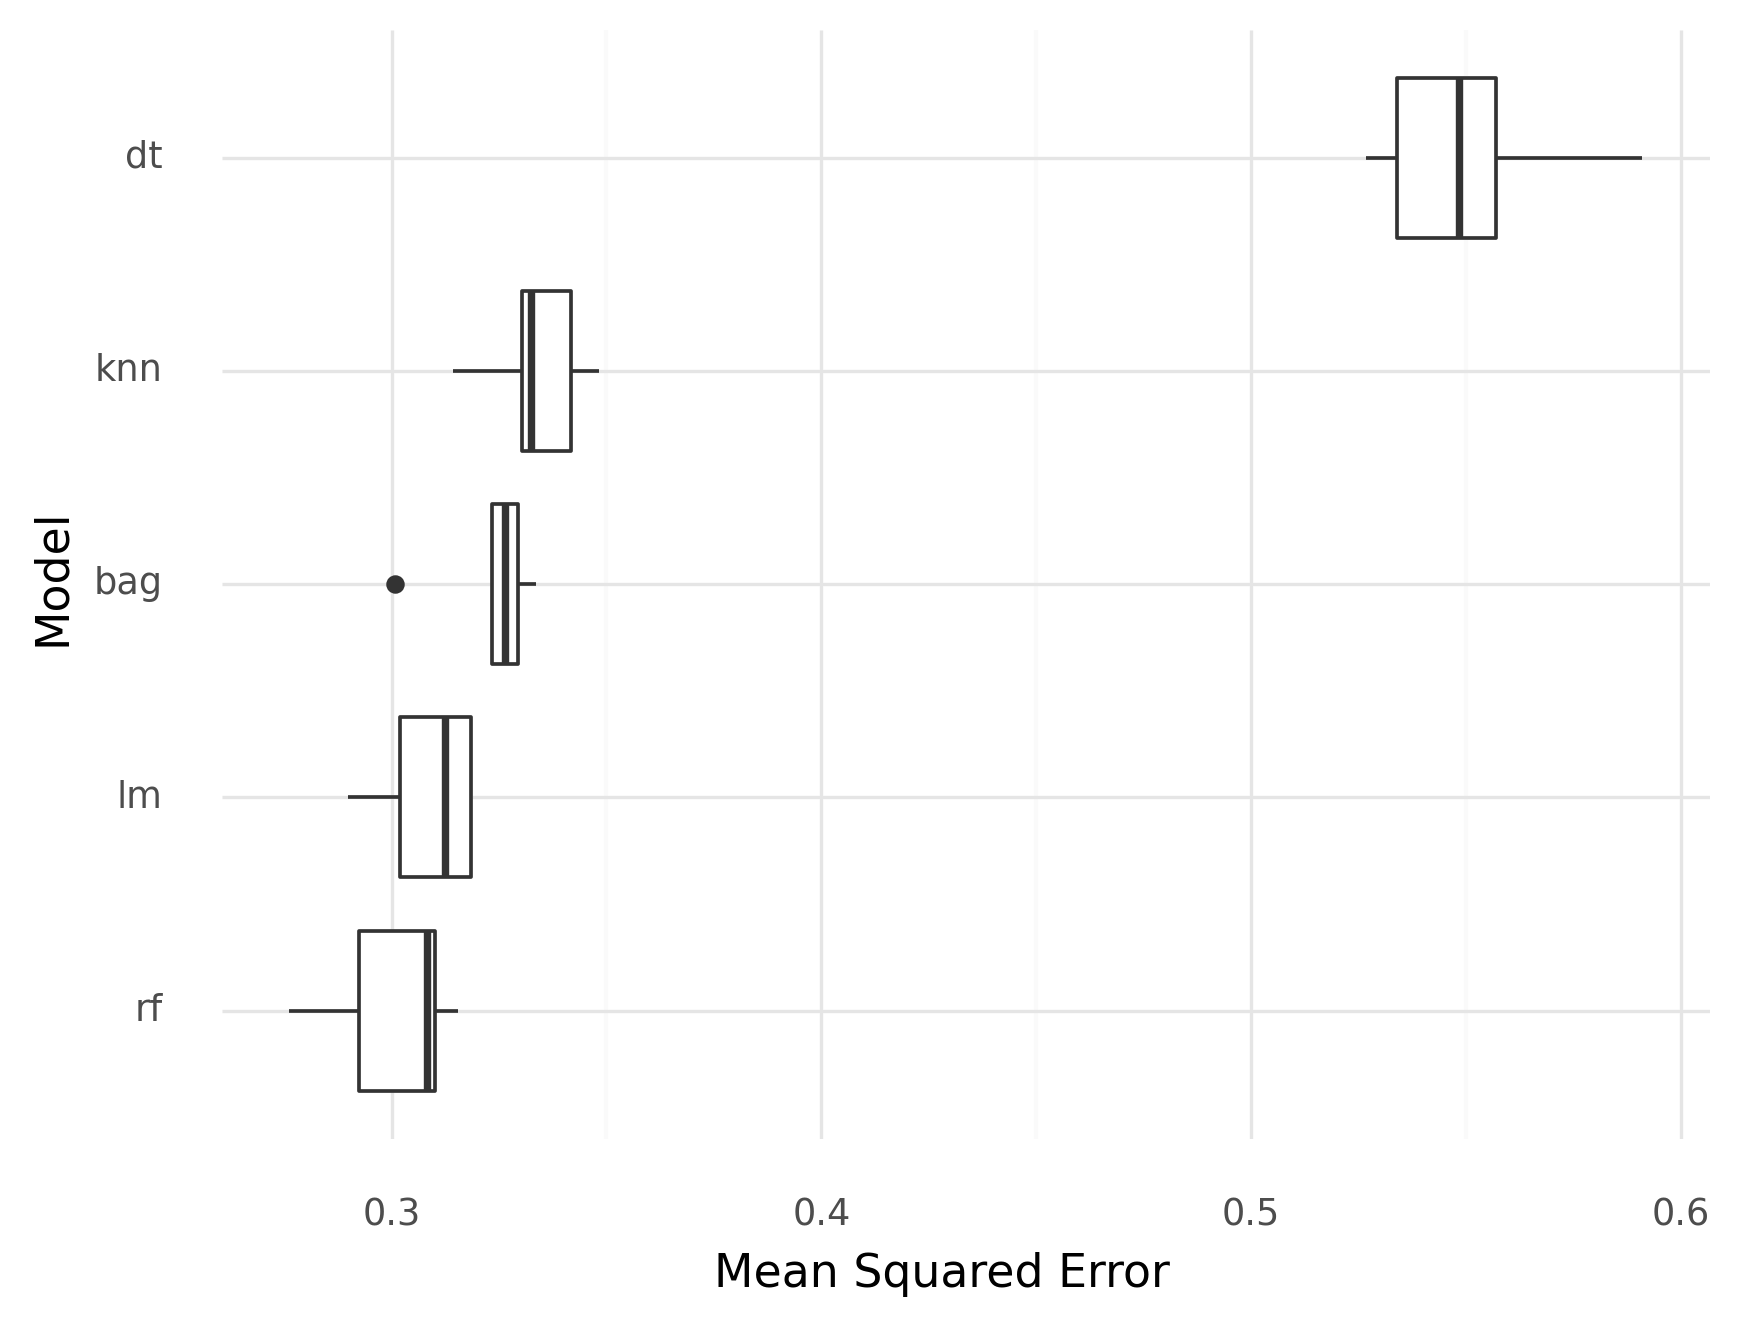

<ggplot: (8785240171767)>

In [17]:
## Order the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

## Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=300)
)

Given the plot, it seems that random forest presents the best performance, and linear model is the second best. Both MSE are around 0.3. Meanwhile, bagging and KNN's performances are close to each other.

### Tuning
By using pipeline, the whole tuning can be achieved within one step.

In [18]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ["BATHRM", "HF_BATHRM", "AC", "BEDRM", "AYB",
                                                                         "GBA", "GRADE", "KITCHENS", "CNDTN", "LANDAREA"])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,20,30,40,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,4,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'HF_BATHRM',
                                                                          'AC',
                                                                          'BEDRM',
                                                                          'AYB',
                                                                          'GBA',
                                                                          'GRADE',
                                                                          'KITCHENS',
                                            

In [19]:
search.best_score_

-0.2972829271670129

In [20]:
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=50), 'model__n_neighbors': 50}

### Testing Performance

In [21]:
## Read the testing data
test= pd.read_csv("../test_data.csv")

## Drop all observations where the outcome is missing 
test = test[~test.LN_PRICE.isna()]

## Only keep those logged prices are not zero
test = test[test.LN_PRICE != 0]

## Log the building area for scaling purposes
test['GBA'] = np.log(test['GBA'])

## Drop all the missing values
test = test.dropna()

## Select the predictor and outcome variable
test_X = test[["BATHRM", "HF_BATHRM", "AC", "BEDRM", "AYB", "GBA", "GRADE", "KITCHENS", "CNDTN","LANDAREA"]]
test_X["AC"] = np.where(test_X["AC"] == "Y", 1, 0)
test_y= test['LN_PRICE']

In [22]:
scaler = pp.MinMaxScaler()
col_names = list(test_X)
test_X = scaler.fit_transform(test_X)

## Convert back into dataframe
test_X = pd.DataFrame(test_X,columns=col_names)

In [23]:
## Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [24]:
m.mean_squared_error(test_y,pred_y)

0.3645342453224032

In [25]:
m.r2_score(test_y,pred_y)

0.39846336334259025

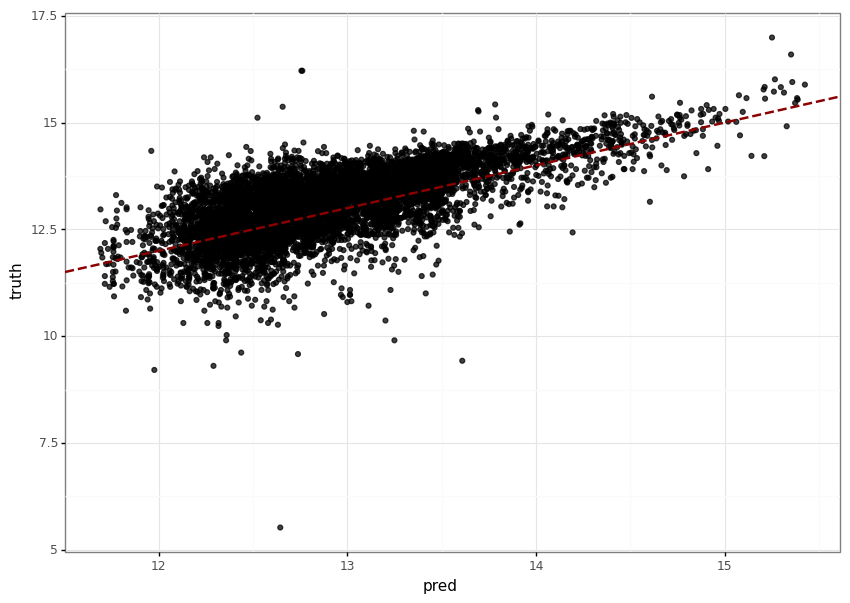

<ggplot: (8767211666893)>

In [42]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

The MSE between prediction and real value is .369, which seems to be a relatively good score. However, it does perform a little bit worse compared to the training data, and it might reflect that using a high-K KNN might better fit the training data and might not produce a generally predictive model than random forest. The R Sqaured score represents that the predicted value can roughly explain 39.8% of the total variance. 